# Deep Evidential Regression (DER)
## Implemented in PyTorch for a cubic polynomial/toy dataset
### Overview
This notebook provides a demonstration of Deep Evidential Regression (DER), as originally published by Amini et al.
https://arxiv.org/pdf/1910.02600.pdf

Amini, A., Schwarting, W., Soleimany, A., & Rus, D. (2020). 
Deep evidential regression. 
Advances in Neural Information Processing Systems, 33, 14927-14937.

Deep Evidential Regression is demonstrated here on a toy polynomial dataset, which was done to
demonstrate the same type of example in the original paper.

Much of this code was adapted from Amini et al. based on the following script:
https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py



In [124]:
# NumPy for toy dataset generation
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import PyTorch
import torch

# Import math module
import math

# Setting figure quality
mpl.rcParams["figure.dpi"] = 300
plt.rcParams["figure.facecolor"] = "white"

## Defining a Custom Dataset Class, Data Generation Function, and Plotting Function

In [125]:
# PyTorch design philosophy asks for any training dataset to be loaded into a PyTorch "Dataset" class.
# We'll do this here. When the dataset class is written, it can be passed to a PyTorch DataLoader which
# controls how the data is fed to the model. We'll define a DataLoader later.
class DER_Dataset(torch.utils.data.Dataset):
    def __init__(self, xLow, xHigh, numPoints, train=True):
        # Generate our polynomial dataset from our custom data generation function
        xData, yData = generate_data(xLow, xHigh, numPoints, train)
        # Convert to tensures, ensure float32 values
        self.xData = torch.as_tensor(xData.copy(), dtype=torch.float32).view(
            numPoints, 1
        )
        self.yData = torch.as_tensor(yData.copy(), dtype=torch.float32).view(
            numPoints, 1
        )

        # NumPy array versions of the data
        self.xDataNP = self.xData.numpy().copy().astype("float32")
        self.yDataNP = self.yData.numpy().copy().astype("float32")

        # Descriptive information about the dataset
        # Length
        self.length = numPoints
        # Theoretical lowest value
        self.xLow = xLow
        # Theoretical highest value
        self.xHigh = xHigh

    # The dataset needs to be iterable (i.e. accessible by an index or some custom enumeration)
    # So, we define a method for accessing the dataset here.
    def __getitem__(self, idx):
        # Get x-Value based on index
        xItem = self.xDataNP.item(idx)
        # Get y-Value baesd on index
        yItem = self.yDataNP.item(idx)

        # Return an ordered pair of points
        return (xItem, yItem)

    # Additionally, PyTorch DataLoader compatibility requires our dataset to have a length function.
    # Returns dataset # of samples
    def __len__(self):
        return self.length


# Function for generating the polynomial dataset
def generate_data(xLow, xHigh, numPoints, train=True):
    # Generate domain values
    x = np.linspace(xLow, xHigh, numPoints)
    # We want the dataset to be an xy array, so add an extra axis for y values via expand_dims
    # Additionally, ensure that values in the dataset are 32-bit floating point numbers.
    x = np.expand_dims(x, 1).astype(np.float32)

    # Establish standard deviation (i.e. uncertainty) for each datapoint.
    # Default to 3 standard deviations

    # If we are generating training data, then we will explicitly tell the model what the uncertainty is
    # because we are doing supervised learning.
    #  np.ones_like makes a constant array of 1's in the shape of x
    if train:
        sigma = 3 * np.ones_like(x)
    # Otherwise if we are generating test data, we want the model to guess uncertainty without
    # being explicitly told what the answer is.
    # np.zeroes_like makes a constant array of 0's in the shape of x
    else:
        sigma = 3 * np.zeros_like(x)

    # Generate the dataset using our x points. If it is training data, generate Gaussian uncertainty based
    # on how 'sigma' was defined. If it is test data, do not generate uncertainty values.
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)

    return x, y


# Function for plotting predictions
def plot_predictions(xTrain, yTrain, xTest, yTest, yPred, nStds=4, kk=0):
    print("\nPredictions")
    print(yPred)

    # Extract the evidential distribution parameters from the ML model's output via torch.split()
    mu, v, alpha, beta = torch.split(yPred, 1, dim=1)

    # All the tensors are of shape [#Rows, 1]
    # Convert the tensors into shape [#Row] via torch.flatten such that they can be plotted without error.
    xTrain = torch.flatten(xTrain)
    yTrain = torch.flatten(yTrain)
    xTest = torch.flatten(xTest)
    yTest = torch.flatten(yTest)
    mu = torch.flatten(mu)
    v = torch.flatten(v)
    alpha = torch.flatten(alpha)
    beta = torch.flatten(beta)

    # Compute the uncertainty from the hyperparameter output, using equations proposed by Amini et al.
    # Epistemic
    var = np.sqrt(beta / (v * (alpha - 1)))
    # Aleatoric
    # var = np.sqrt(beta / (alpha - 1))
    var = np.minimum(var, 1e3)

    # Plotting Code
    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(xTrain, yTrain, s=1.0, c="#463c3c", zorder=0, label="Train")
    plt.plot(xTest, yTest, "r--", zorder=2, label="True")
    plt.plot(xTest, mu, color="#007cab", zorder=3, label="Prediction")
    plt.plot([-4, -4], [-150, 150], "k--", alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], "k--", alpha=0.4, zorder=0)

    # Shade the area of uncertainty associated with the toy dataset
    for k in np.linspace(0, nStds, 4):
        plt.fill_between(
            xTest,
            (mu - k * var),
            (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor="#00aeef",
            linewidth=0,
            zorder=1,
            label="Uncertainty" if k == 0 else None,
        )

    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.title("Evidential, \nwith regularization")
    plt.show()

## Defining a Custom Dataset Class, Data Generation Function, and Plotting Function

In [126]:
# One of the steps to implementing DER is creating a custom output layer for the model
# This custom output layer has the same weight/bias initialization of a standard dense, linear PyTorch layer
# Except, it calculates evidential distribution parameters
class DenseNormalGamma(torch.nn.Module):
    # Default output size is 4 because there are 4 parameters to the evidential distribution
    def __init__(self, inputSize, outputSize=4):
        super().__init__()
        self.inputSize, self.outputSize = inputSize, outputSize

        # Neural network weight tensor
        weights = torch.Tensor(inputSize, outputSize)

        # torch.nn.Parameter() converts a tensort to a special type of tensor that can be used as a module parameter
        self.weights = torch.nn.Parameter(weights)

        # Bias tensor
        bias = torch.Tensor(outputSize)

        # Turn the bias into a module parameter as well
        self.bias = torch.nn.Parameter(bias)

        # Initializing the weights and biases
        # Weight initialization (equivalent to standard dense, linear PyTorch layer)
        torch.nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)

        # Bias initialization (equivalent to standard dense, linear PyTorch layer)
        torch.nn.init.uniform_(self.bias, -bound, bound)

    # Define a new function called evidence()
    # All this function does is perform SoftPlus on the evidential distribution parameters.
    # This has the effect of ensuring all parameters are positive at all times
    def evidence(self, x):
        return torch.nn.functional.softplus(x)

    # Now a new function needs to be defined to describe how data is forward-passed through the model
    def forward(self, x):
        # Multiply the incoming data by the neural network edge weights
        self.weightMultipliedData = torch.matmul(x, self.weights)
        # Add the neural network node biases
        self.biasesAdded = torch.add(self.weightMultipliedData, self.bias)

        # Split the output layer (which contains evidential hyperdist. parameters)
        # into individual evidential distribution parameters
        mu, logv, logalpha, logbeta = torch.split(self.biasesAdded, 1, dim=1)

        # Ensure positive values to the hyperdistribution parameters
        v = self.evidence(logv)
        logAlphaEvidence = self.evidence(logalpha)
        alpha = logAlphaEvidence + 1
        beta = self.evidence(logbeta)

        # Return the overall output of the positive-ensured hyperdistr. parameters.
        # This is our forward pass result.
        return torch.cat([mu, v, alpha, beta], dim=1)


# Creating the PyTorch Model Class for the ANN that we will put evidential regression on.
class DER_ANN(torch.nn.Module):
    def __init__(self, numInputs=64, numOutputs=64):
        super(DER_ANN, self).__init__()

        self.linear1 = torch.nn.Linear(numInputs, numOutputs)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(numOutputs, numOutputs)
        self.activation2 = torch.nn.ReLU()
        # Evidential layer goes here
        self.DenseNormalGamma = DenseNormalGamma(inputSize=numOutputs)

    # Define forward passing of the neural network
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        # Here, we call the custom forward pass function we wrote for our custom evidential layer.
        x = self.DenseNormalGamma(x)

        return x

## Defining a Custom Evidential Loss Function

In [127]:
# Custom function for calculating the negative log likelihood of the evidential loss function
def NIG_NLL(y, gamma, v, alpha, beta, reduce=True):
    twoBlambda = 2 * beta * (1 + v)

    nll = (
        0.5 * torch.log(np.pi / v)
        - alpha * torch.log(twoBlambda)
        + (alpha + 0.5) * torch.log(v * (y - gamma) ** 2 + twoBlambda)
        + torch.lgamma(alpha)
        - torch.lgamma(alpha + 0.5)
    )

    return torch.mean(nll) if reduce else nll


# Custom function for calculating the regularizer term of the evidential loss function
def NIG_Reg(y, gamma, v, alpha, beta, reduce=True):
    # Get the predictive error
    error = torch.abs(y - gamma)

    evidence = 2 * v + (alpha)
    reg = error * evidence

    return torch.mean(reg) if reduce else reg


# One of the steps to implementing DER is to define a custom loss function for the neural network
# This is done here.
def EvidentialRegression(yTrue, evidentialOutput, coeff=1.0):
    # Get the evidential distribution parameters from the model output
    gamma, v, alpha, beta = torch.split(evidentialOutput, 1, dim=1)
    # Calculate the negative log likelihood term of the evidential loss function
    loss_nll = NIG_NLL(yTrue, gamma, v, alpha, beta, reduce=True)
    # Calculate the regularizer term (see original paper)
    loss_reg = NIG_Reg(yTrue, gamma, v, alpha, beta, reduce=True)

    return loss_nll + (coeff * loss_reg)

## Generate Training/Test Data

In [128]:
# Set a global NumPy seed for random number generation, improves reproducibility.
np.random.seed(0)
# Set a global PyTorch seed for random number generation, improves reproducibility.
torch.manual_seed(0)

# Generate training dataset
# xTrain, yTrain = generate_data(-4, 4, 1000, train = True)

# Generate test dataset
# Train = False tells the function to not generate uncertainty values.
# xTest, yTest = generate_data(-7, 7, 1000, train = False)

trainingData = DER_Dataset(-4, 4, 1000, train=True)
testData = DER_Dataset(-7, 7, 1000, train=False)

## Define a Dataloader for Feeding Data to Model

In [129]:
# Specify a batch size to load into the model for mini-batch optimization.
trainBatchSize = 100
# Specify a batch size to load into the model for making test predictions.
evalBatchSize = trainBatchSize

# Create the dataloader.
# PyTorch design philosophy uses "DataLoader" objects to feed the data to the ML model during training and inference
# One defines a DataLoader and then passes the data to it.

trainDL = torch.utils.data.DataLoader(
    trainingData, batch_size=trainBatchSize, shuffle=False
)
testDL = torch.utils.data.DataLoader(testData, batch_size=evalBatchSize, shuffle=False)

## Instantiate the Model Before Training

In [130]:
# Instantiate the model and print the model architecture.

myDERModel = DER_ANN(numInputs=1)

# Cast all model parameters to 64-bit floating point numbers
# All the numbers have the be the same datatype (i.e. 64-bit) for PyTorch to accept the data
myDERModel = myDERModel.double()

myDERModel

DER_ANN(
  (linear1): Linear(in_features=1, out_features=64, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (activation2): ReLU()
  (DenseNormalGamma): DenseNormalGamma()
)

## Instantiate an Optimizer Before Training

In [131]:
# Define an optimizer
optimizer = torch.optim.Adam(myDERModel.parameters(), lr=5e-4, eps=1e-07)

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-07
    foreach: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)

## Train the model

In [138]:
# Number of epochs to train for.
numEpoch = 500

# for i, batch in enumerate(trainDL):
#    print(i, batch)

for epoch in range(numEpoch):
    lossCounter = 0.0

    # Get the data
    for batchIndex, batchData in enumerate(trainDL):
        # print(batchIndex)

        xData = batchData[0]
        xData = xData.view(trainBatchSize, 1)
        yData = batchData[1]
        yData = yData.view(trainBatchSize, 1)

        # print(yData.size())
        # Zero the parameter gradients between each epoch (because we start fresh with the training each epoch)
        optimizer.zero_grad()

        # Forward passing
        outputs = myDERModel(xData)
        # Calculating evidential loss
        # For epistemic example
        coeffChoice = 4e-2
        loss = EvidentialRegression(yData, outputs, coeff=coeffChoice)
        # Backwards passing, automatically performed
        loss.backward()
        # Continue with optimization
        optimizer.step()

        # Statistics to show training
        lossCounter += loss.item()
        # Every 10 mini-batches and 5 epochs, print
        if (batchIndex % 10 == 9) and (epoch % 5 == 4):
            print(
                "[%d, %5d] loss: %.3f" % (epoch + 1, batchIndex + 1, lossCounter / 10)
            )
            epochLoss = lossCounter
            # Reset the loss counter for the next set of mini-batches
            lossCounter = 0.0

print("\nTraining Complete.\n")

# Final training statistics
print("Final loss: %.3f" % (epochLoss / 10))

[5,    10] loss: 2.648
[10,    10] loss: 2.658
[15,    10] loss: 2.685
[20,    10] loss: 2.666
[25,    10] loss: 2.661
[30,    10] loss: 2.662
[35,    10] loss: 2.663
[40,    10] loss: 2.665
[45,    10] loss: 2.664
[50,    10] loss: 2.661
[55,    10] loss: 2.665
[60,    10] loss: 2.657
[65,    10] loss: 2.655
[70,    10] loss: 2.655
[75,    10] loss: 2.657
[80,    10] loss: 2.660
[85,    10] loss: 2.664
[90,    10] loss: 2.662
[95,    10] loss: 2.658
[100,    10] loss: 2.654
[105,    10] loss: 2.652
[110,    10] loss: 2.654
[115,    10] loss: 2.655
[120,    10] loss: 2.657
[125,    10] loss: 2.662
[130,    10] loss: 2.664
[135,    10] loss: 2.658
[140,    10] loss: 2.653
[145,    10] loss: 2.655
[150,    10] loss: 2.658
[155,    10] loss: 2.674
[160,    10] loss: 2.653
[165,    10] loss: 2.655
[170,    10] loss: 2.658
[175,    10] loss: 2.660
[180,    10] loss: 2.664
[185,    10] loss: 2.665
[190,    10] loss: 2.659
[195,    10] loss: 2.654
[200,    10] loss: 2.651
[205,    10] loss: 2

## Make Predictions with the Model

In [136]:
# The model is now trained, so let's make some predictions on the test dataset.

# Disable the autograd engine, as we only need gradients in our model during training.
# Disabling this improves inference speed

with torch.no_grad():
    # Set the model into evaluation mode. This ensures all model layers behave properly while making predictions.
    myDERModel.eval()

    # Get the data
    for batchIndex, batchData in enumerate(testDL):
        xData = batchData[0]
        xData = xData.view(evalBatchSize, 1)

        # Make Predictions
        outputs = myDERModel(xData)

        # Take each mini-batch prediction set and combine them via concatenation to get the total prediction set.
        if batchIndex != 0:
            # Make Predictions
            outputs = myDERModel(xData)
            outputs = torch.cat((previousOutputs, outputs), dim=0)
            previousOutputs = outputs
        else:
            previousOutputs = myDERModel(xData)

print("\nInference Complete.\n")
print("Prediction Set Dimensions:")
print(outputs.size())


Inference Complete.

Prediction Set Dimensions:
torch.Size([1000, 4])


## Plot Prediction Trendline with the Real Data and Real Trendline


Predictions
tensor([[-1.2454e+02,  3.3181e-09,  1.5661e+00,  3.1064e-05],
        [-1.2424e+02,  3.4762e-09,  1.5654e+00,  3.1651e-05],
        [-1.2395e+02,  3.6419e-09,  1.5648e+00,  3.2248e-05],
        ...,
        [ 1.3204e+02,  9.9250e-08,  1.6644e+00,  5.5629e-05],
        [ 1.3236e+02,  9.5397e-08,  1.6663e+00,  5.4617e-05],
        [ 1.3268e+02,  9.1694e-08,  1.6683e+00,  5.3623e-05]],
       dtype=torch.float64)


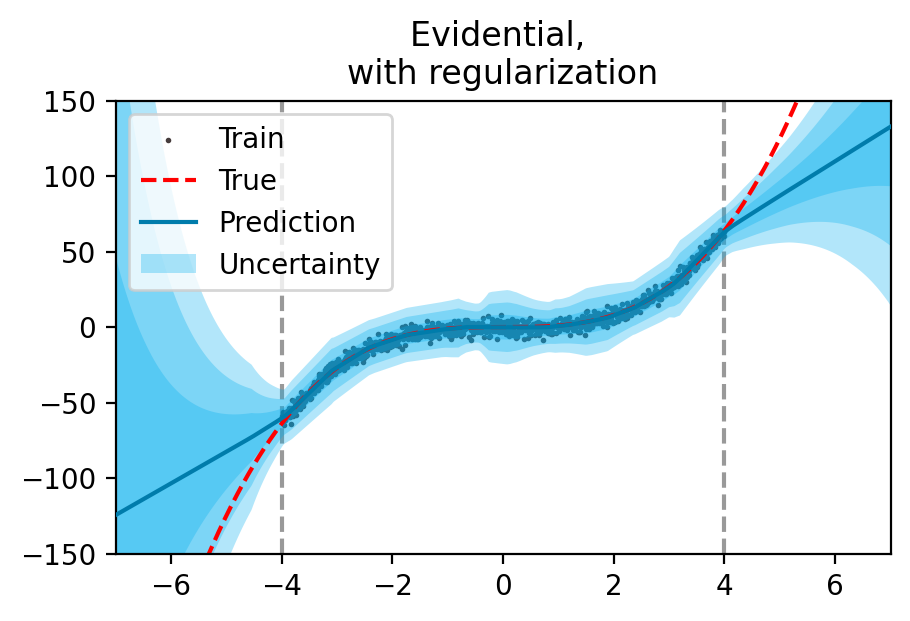

In [137]:
plot_predictions(
    trainingData.xData, trainingData.yData, testData.xData, testData.yData, outputs
)